In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import scipy.optimize as sco
import scipy.constants as c
from scipy.optimize import curve_fit as cf
import pandas as pd

In [8]:
def gaussian(x,A,mu,sig,b):
    return A* np.exp( - (x-mu)**2 / 2 / sig**2 ) +b
def gerade(x,a,b):
    return a*x +b

pos=np.linspace(20,180,41) #20cm und 180cm sind die Enden des Scintialtors
guesses=np.linspace(300,1000,len(pos))

dpos=np.array([1/2 for i in pos])

C:\Users\Gunther\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


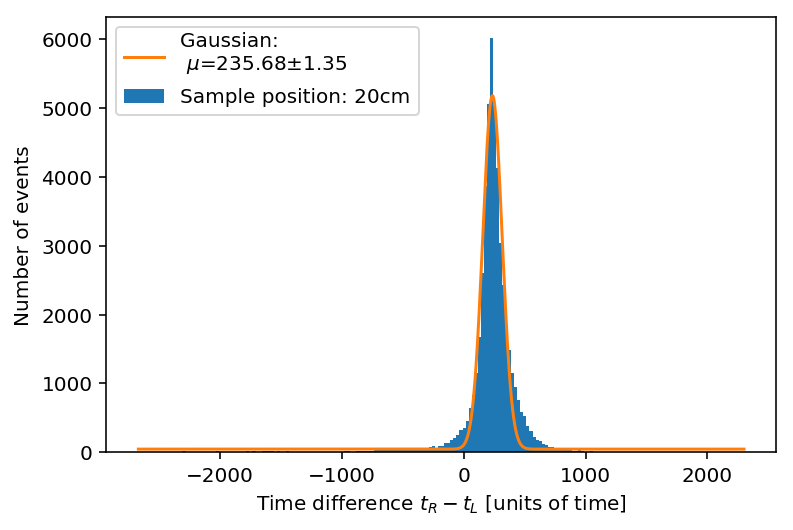

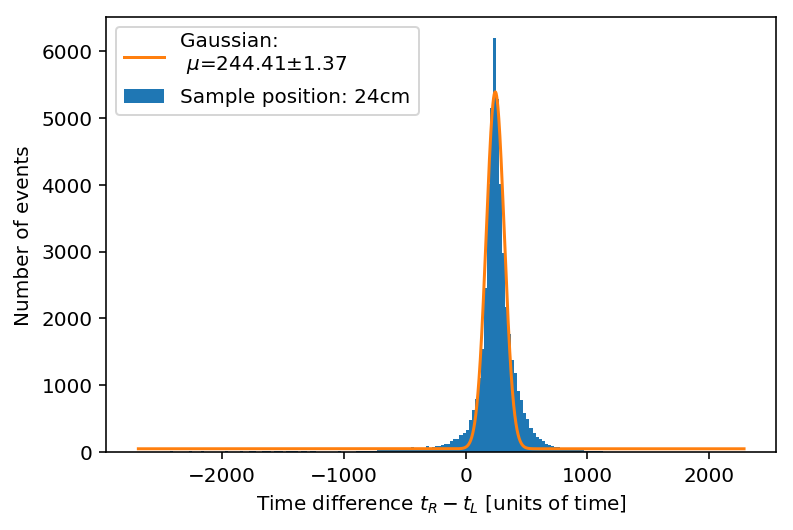

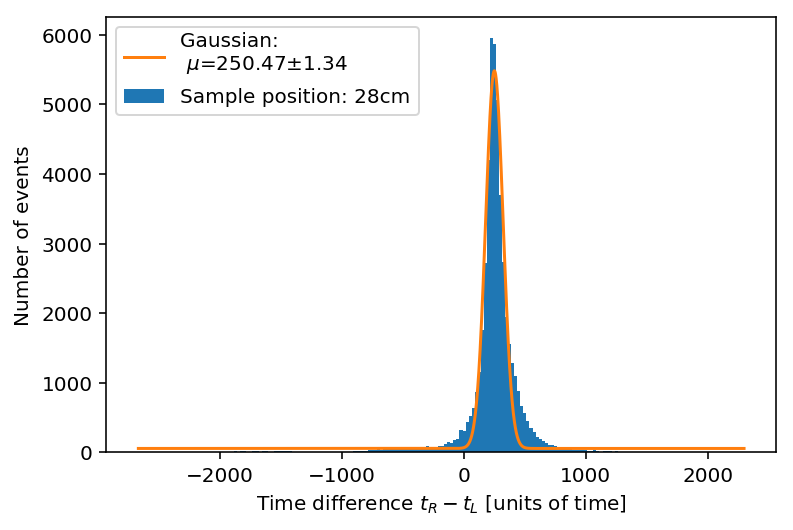

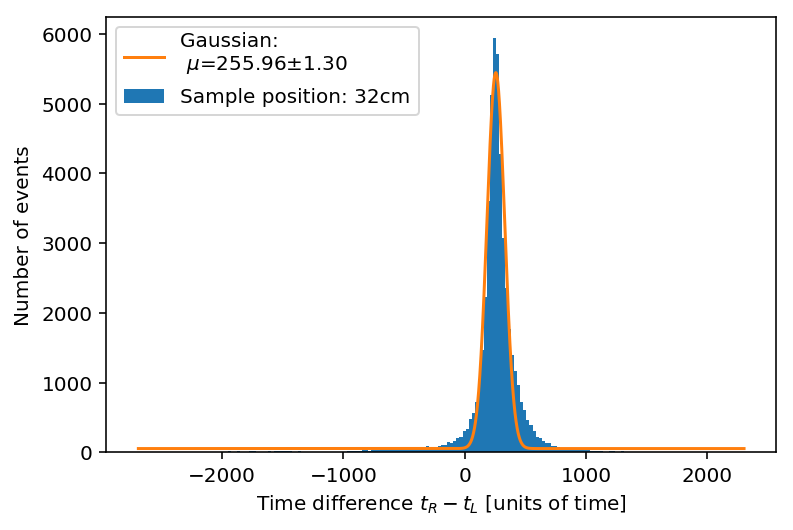

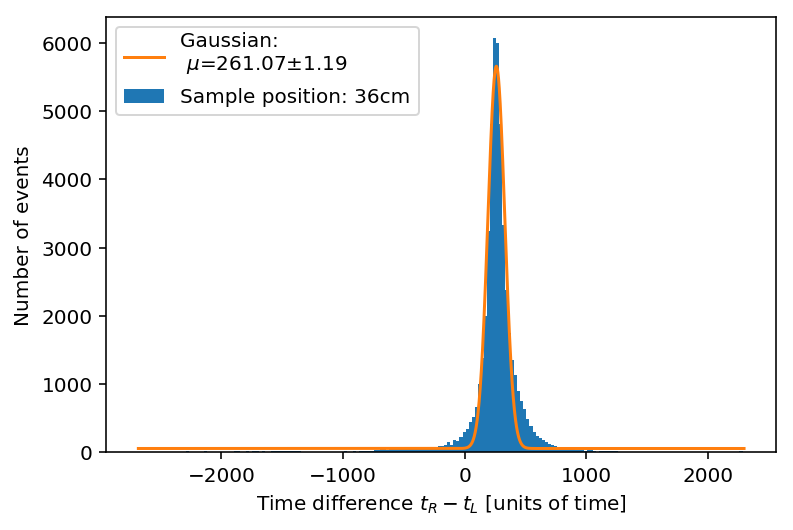

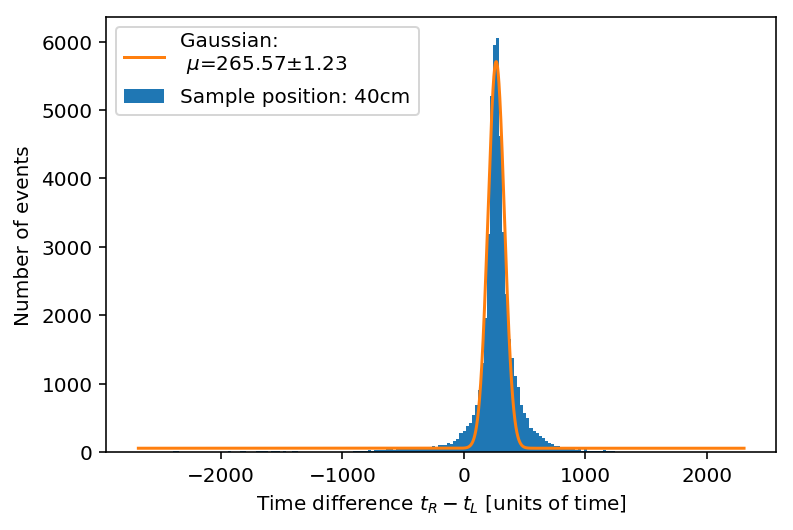

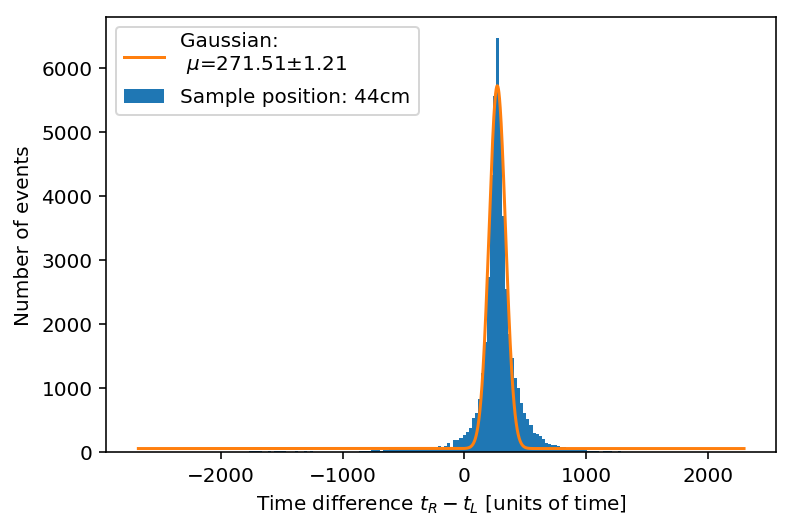

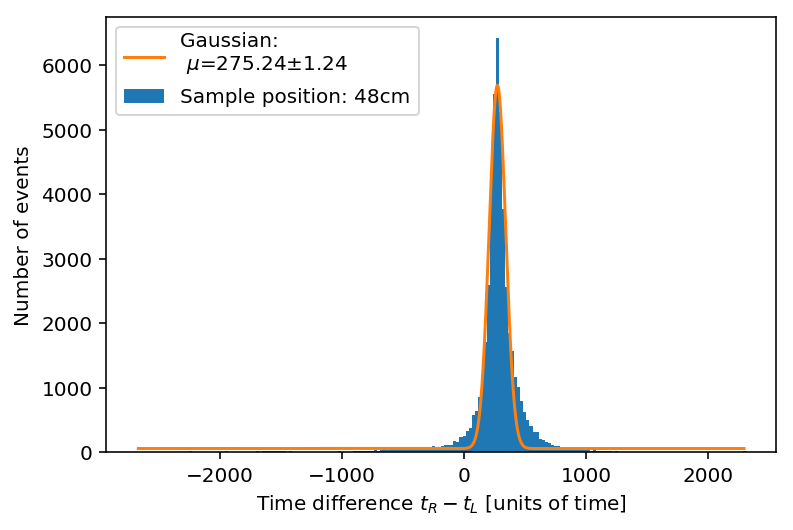

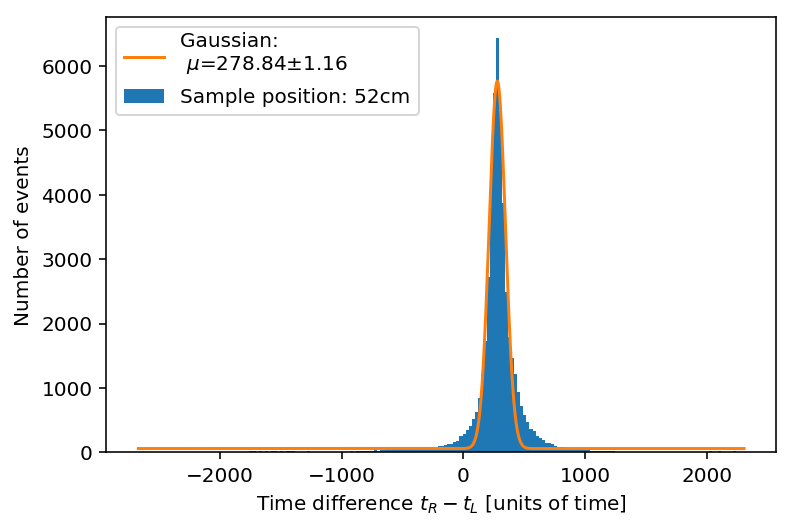

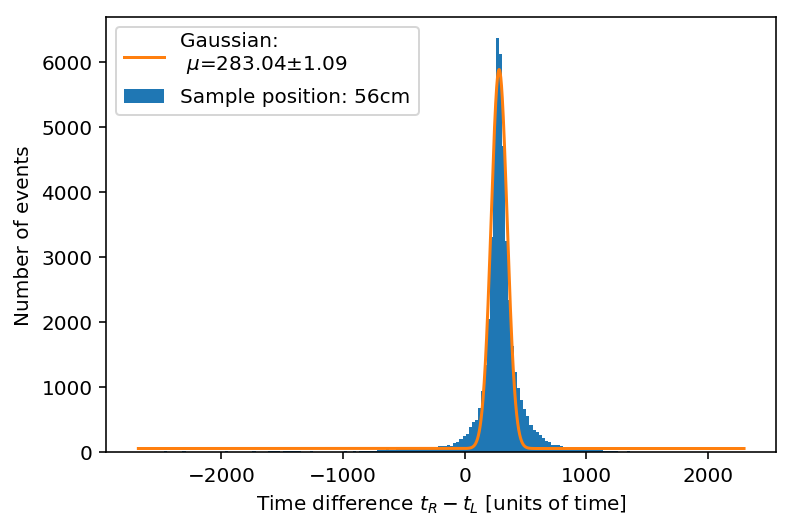

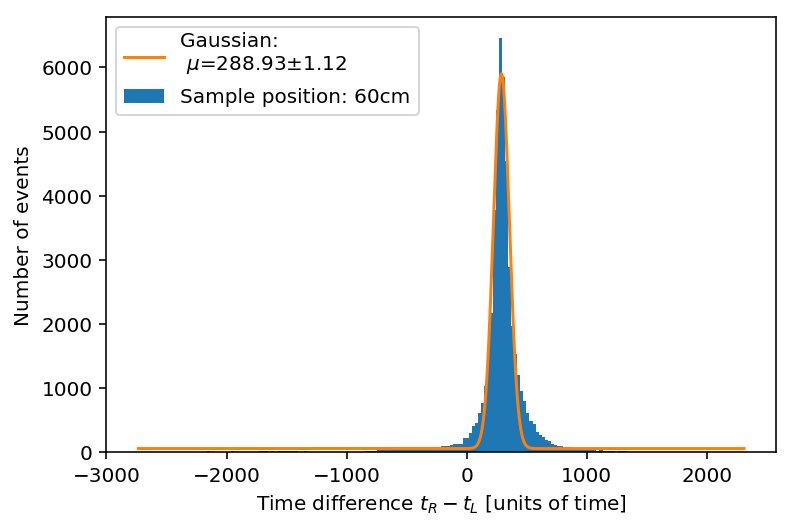

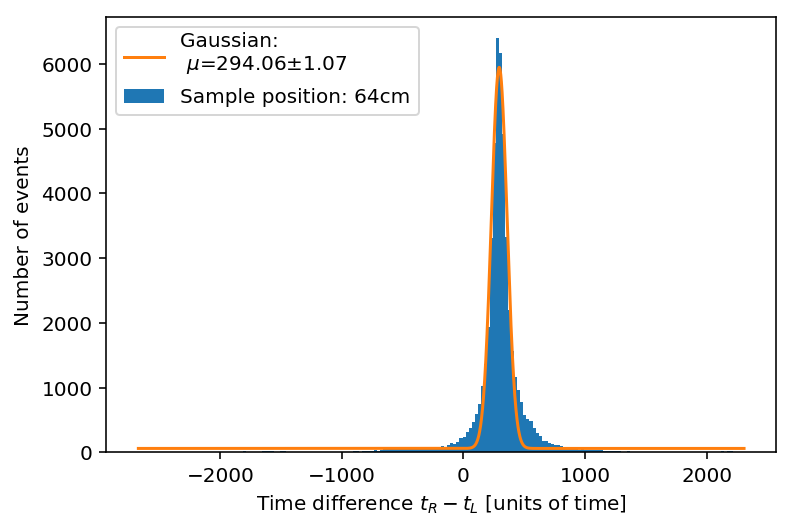

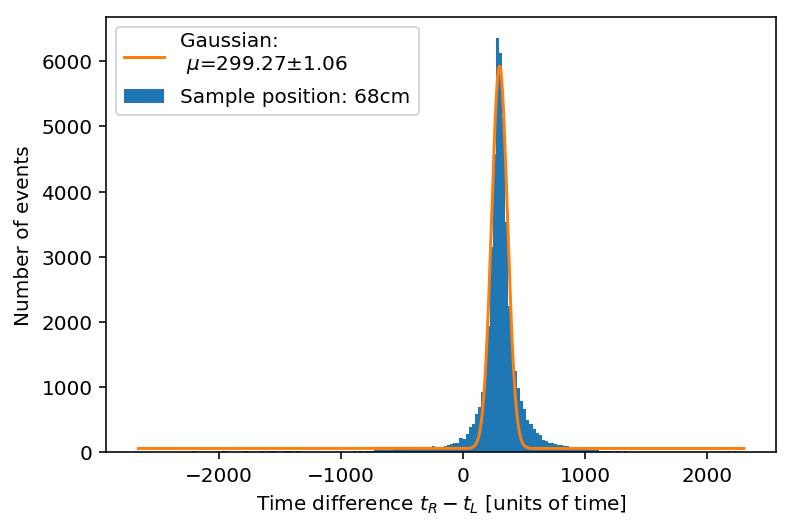

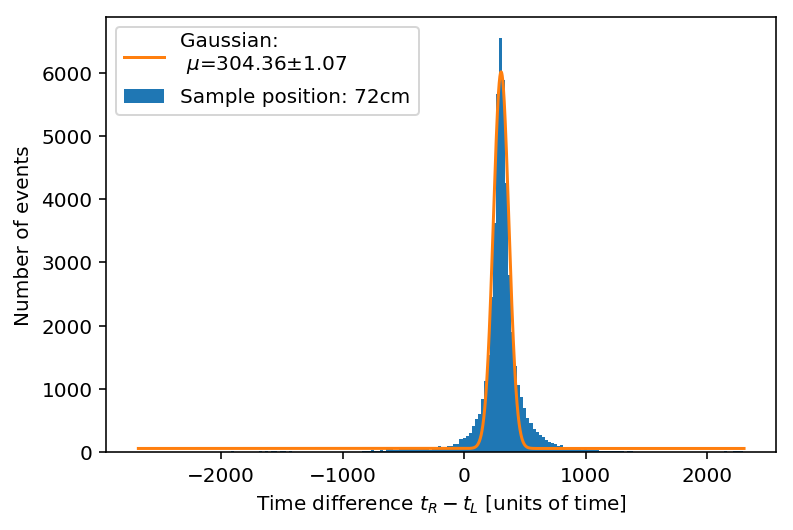

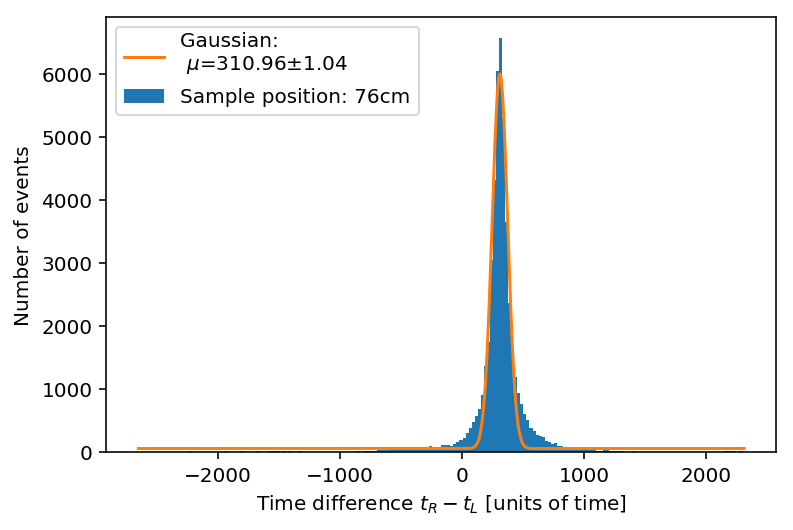

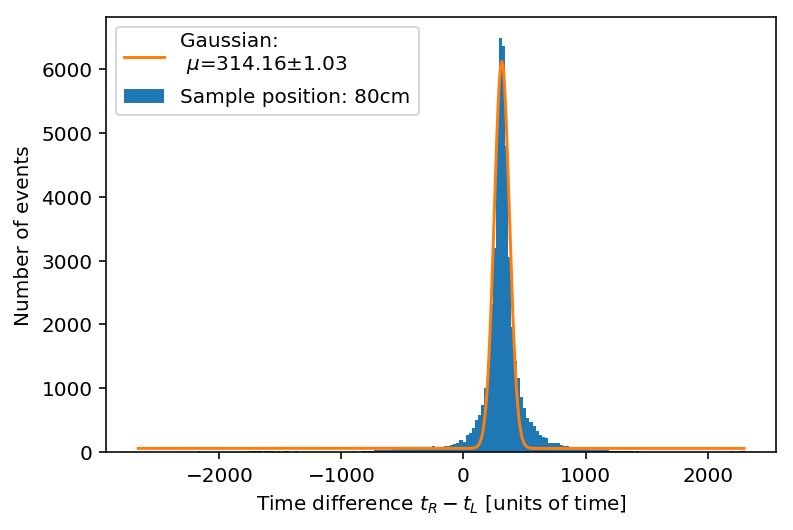

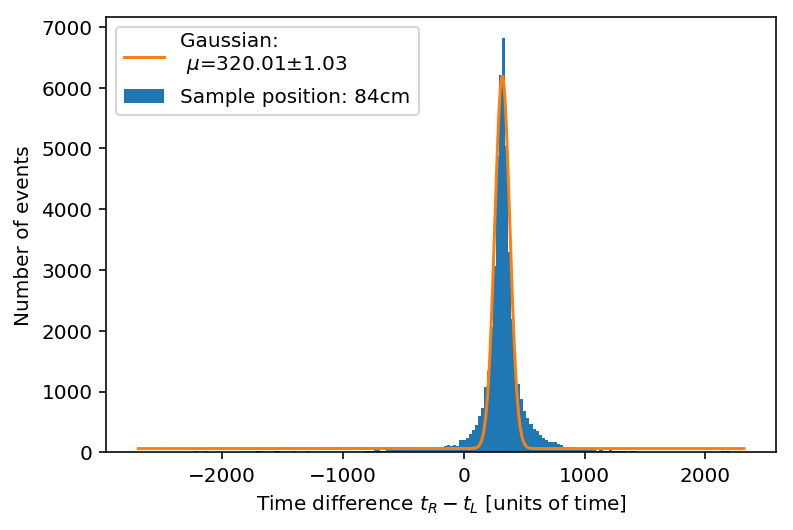

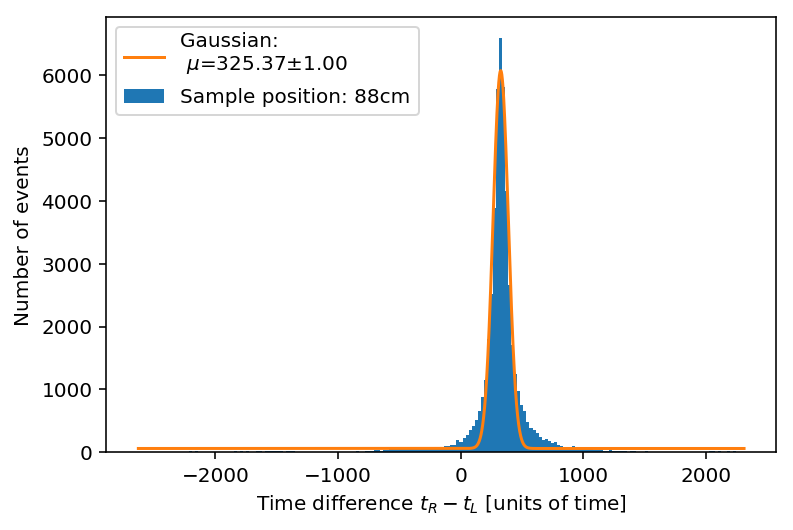

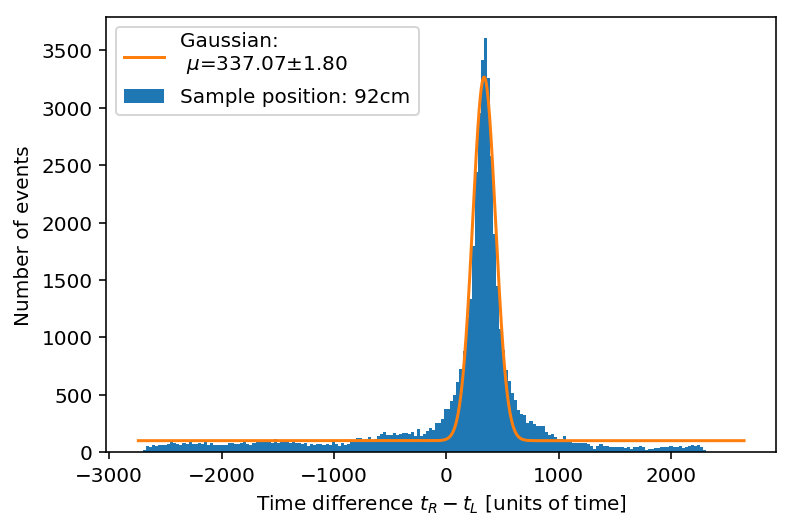

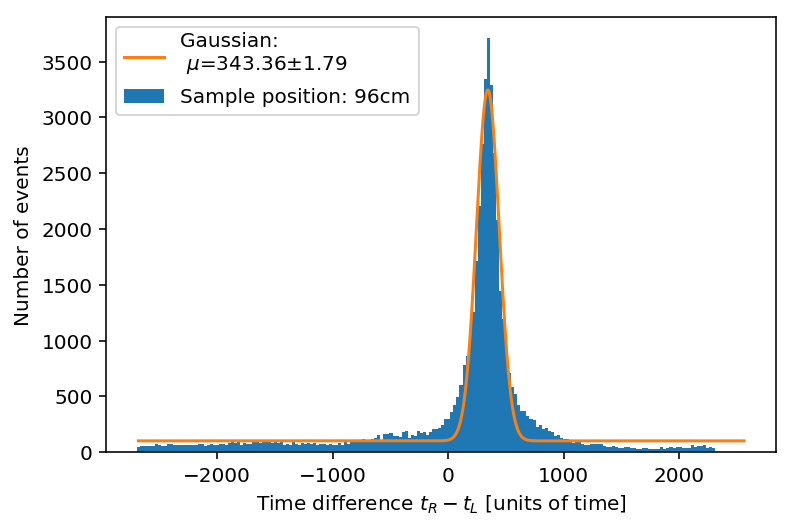

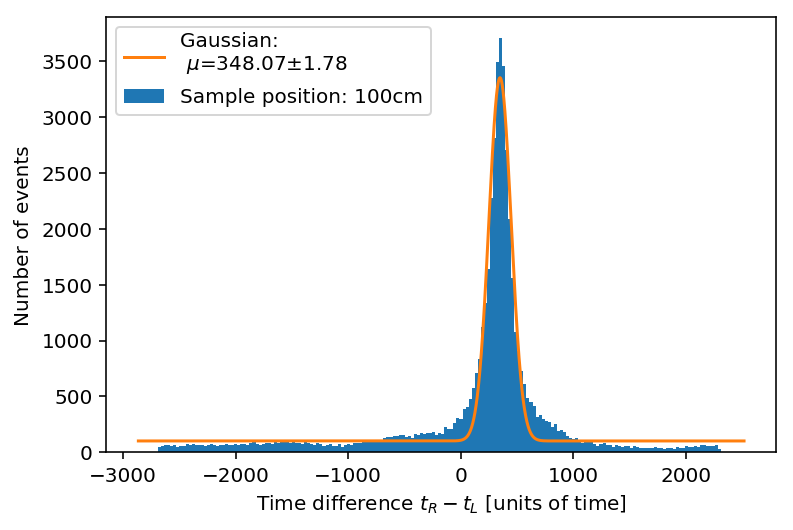

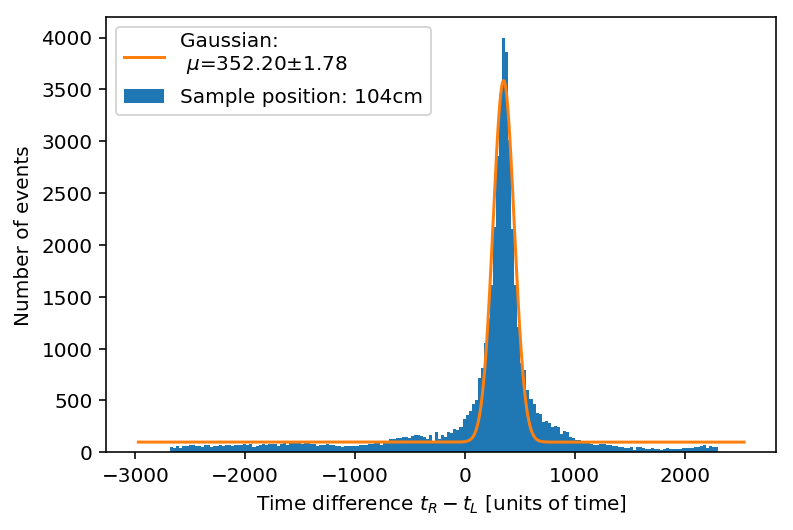

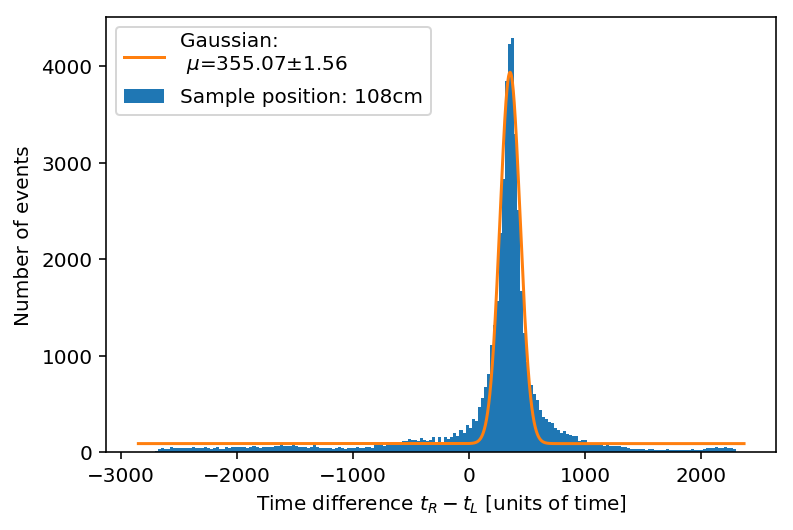

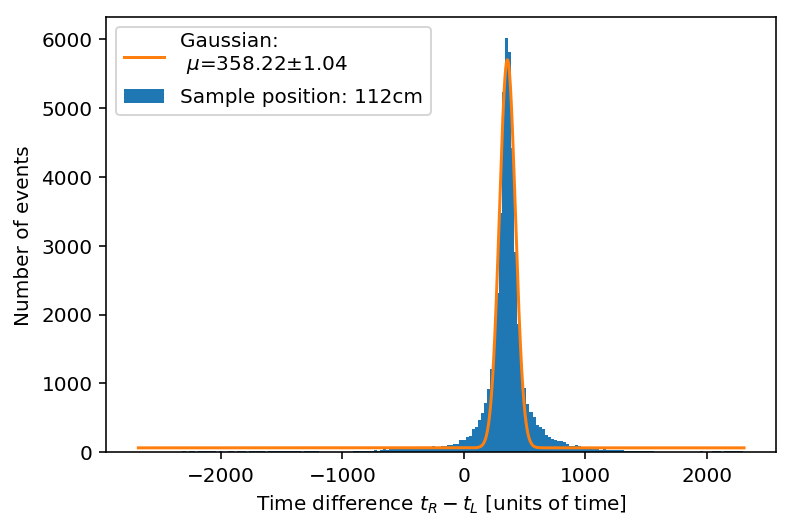

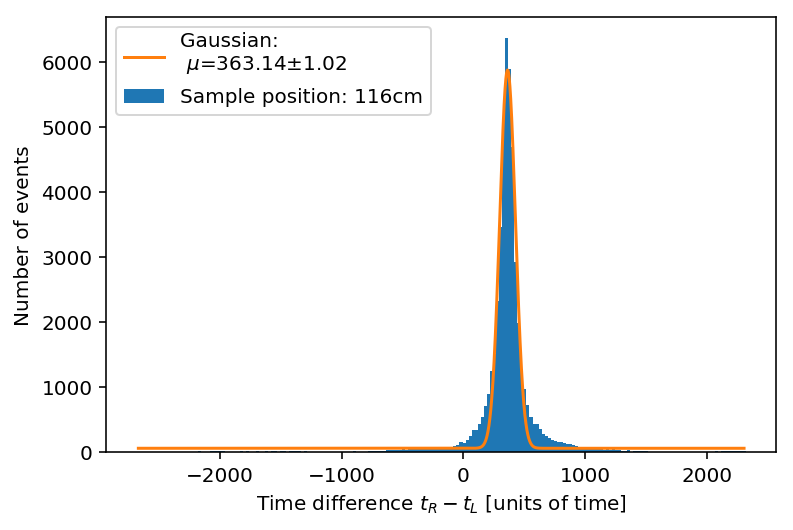

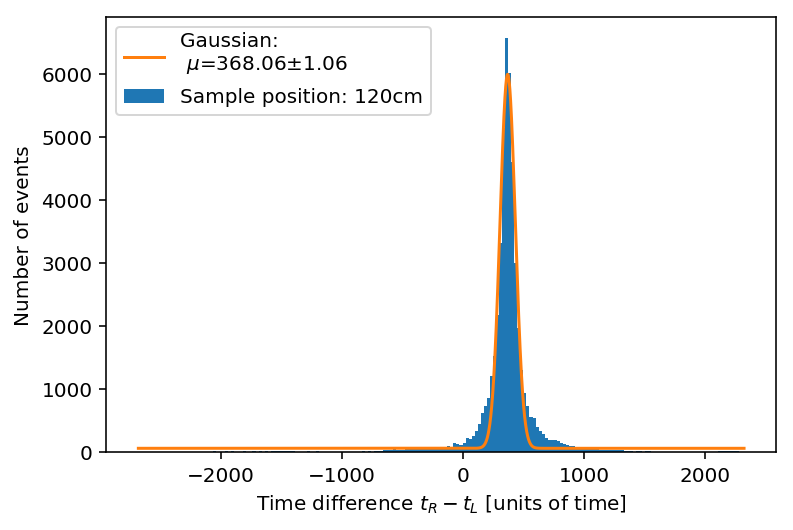

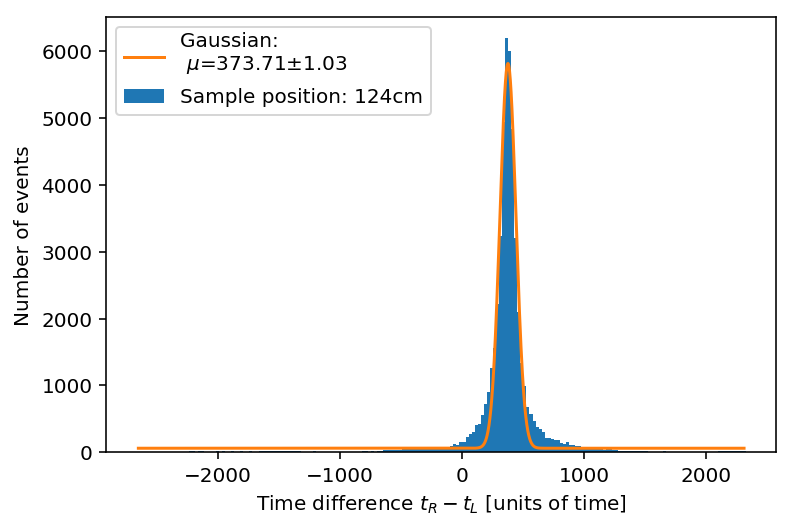

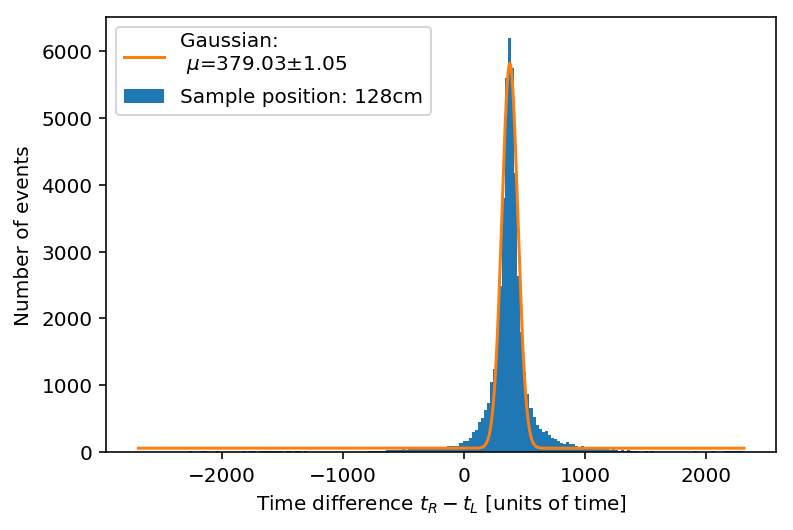

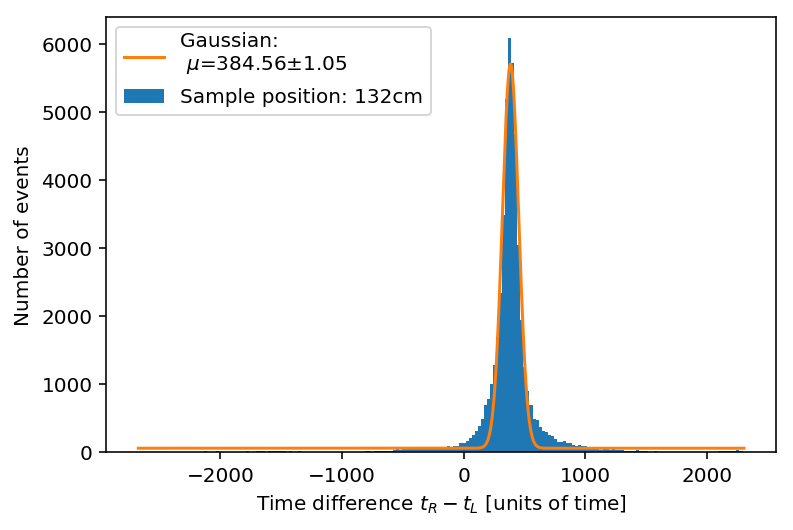

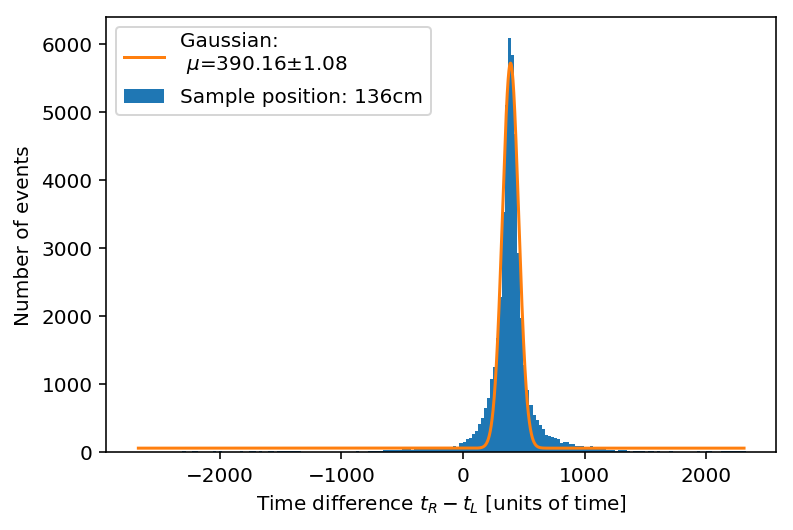

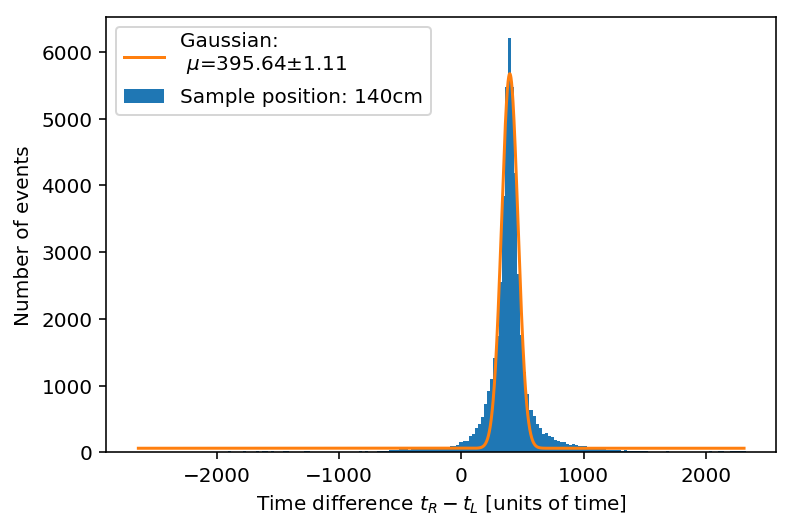

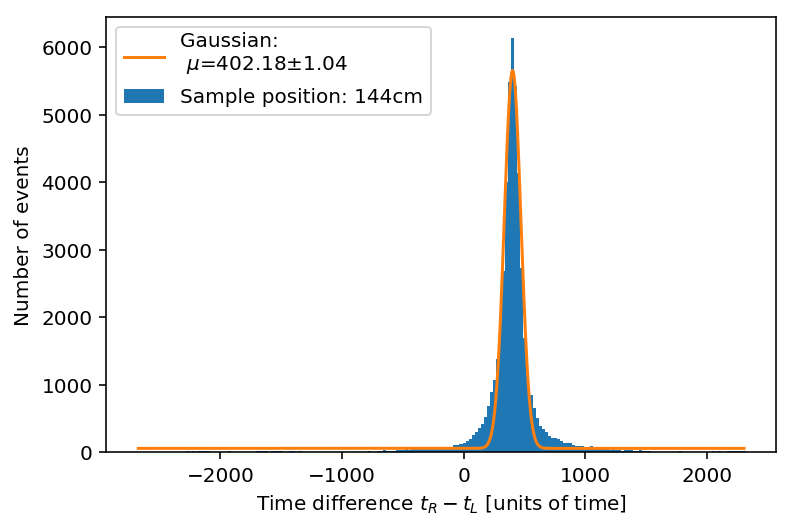

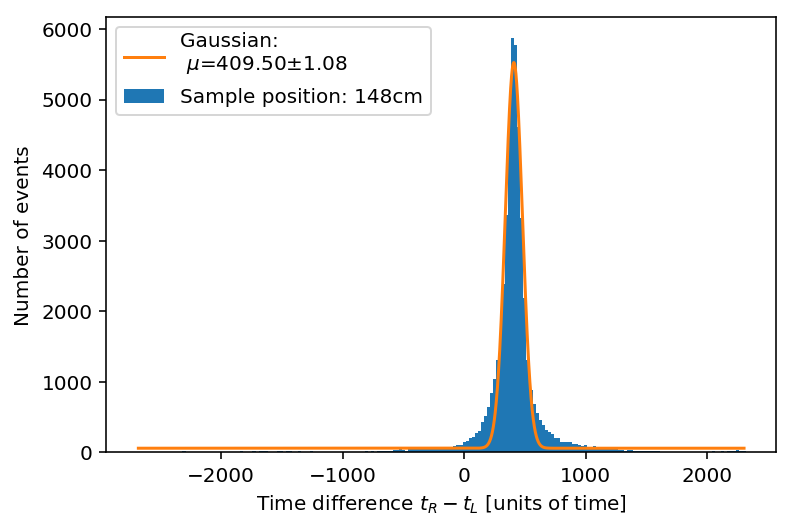

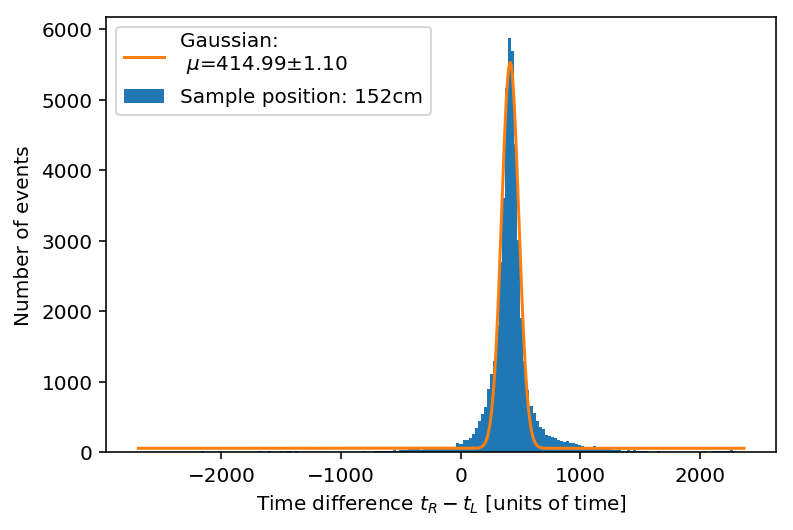

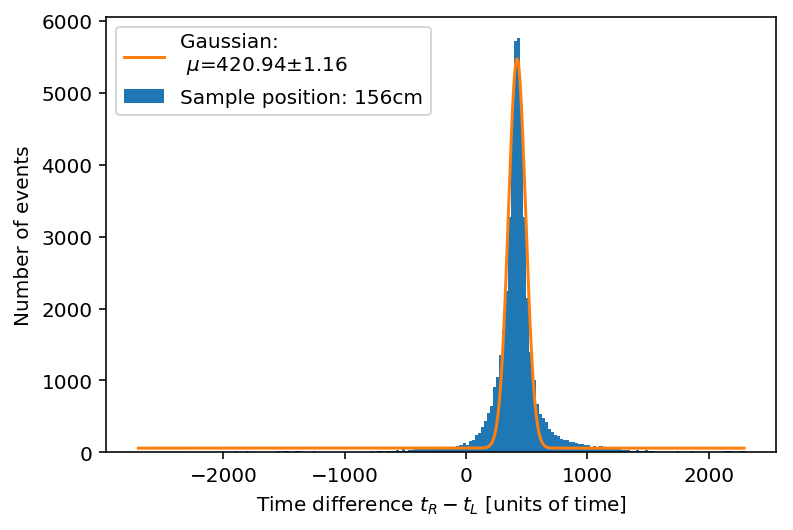

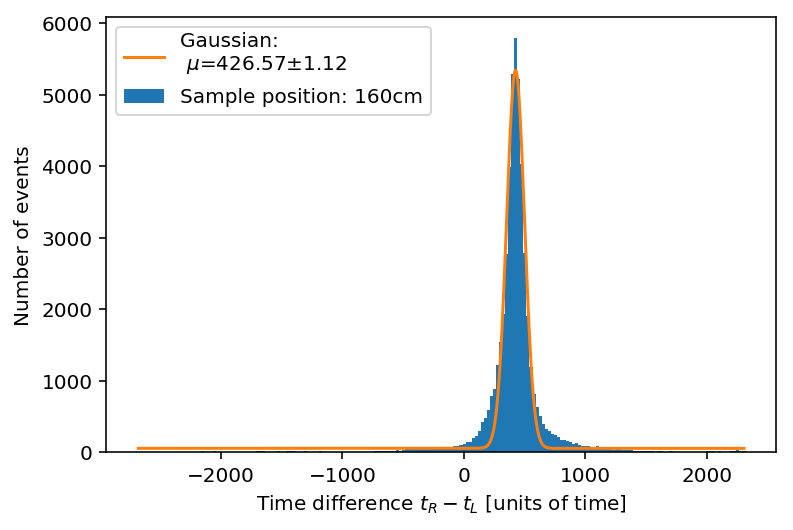

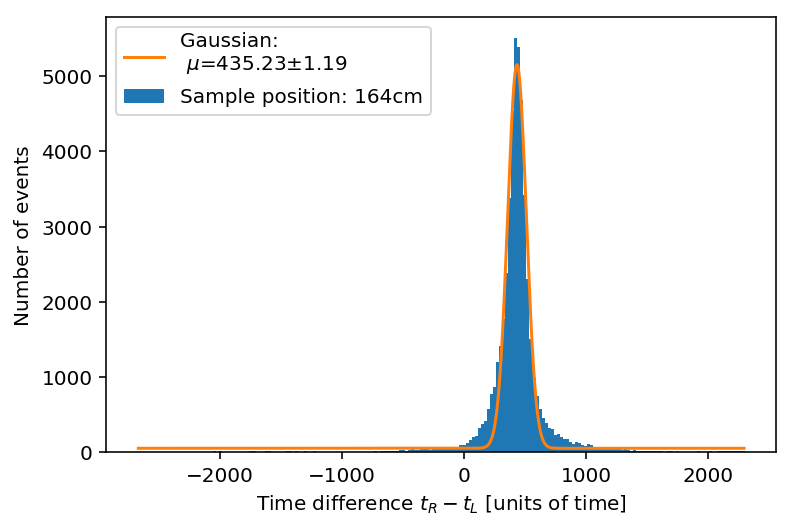

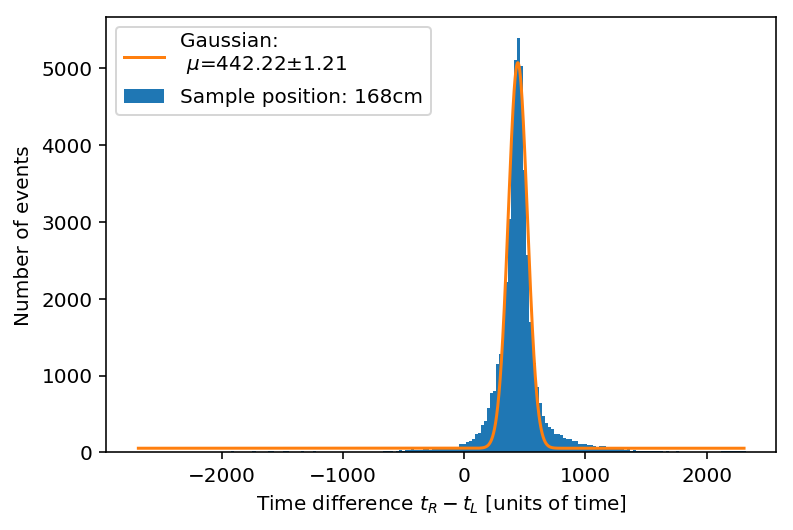

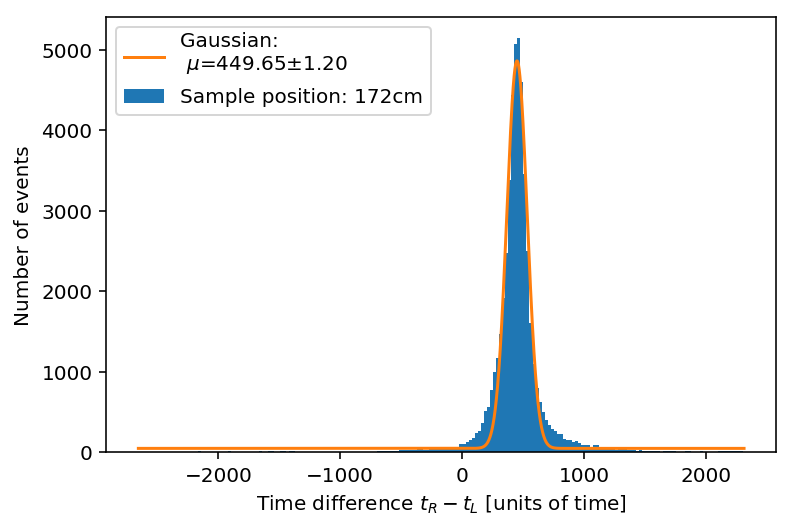

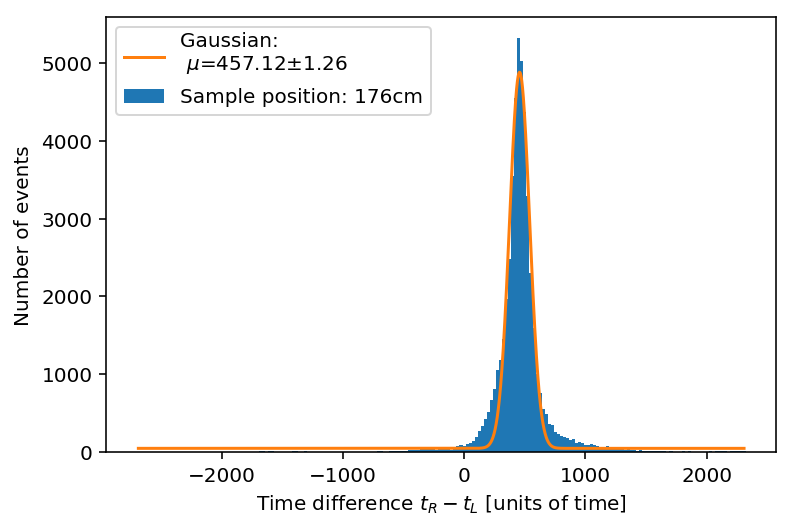

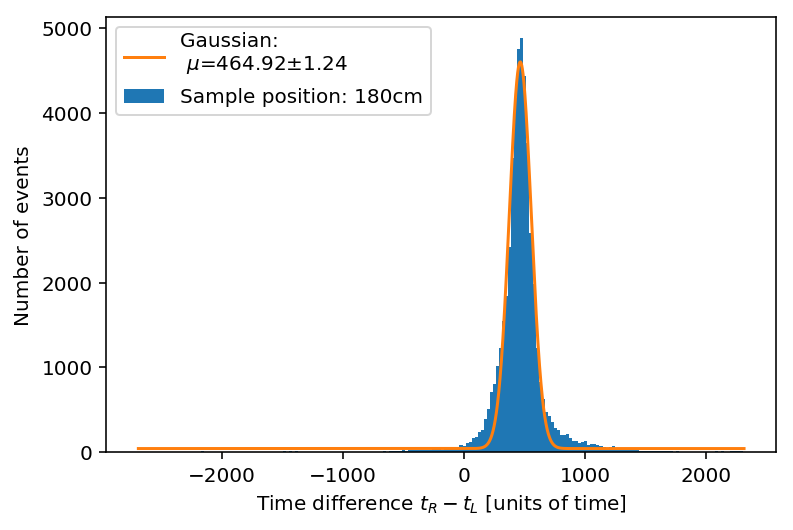

In [3]:
def getHist(pos, guess_mu):
    p=int(pos)
    data=pd.read_table("Data/dataAt{}".format(p),skiprows=0,delim_whitespace =True)
    num=np.array(data.values[:,0])
    ADC1=np.array(data.values[:,1])
    ADC2=np.array(data.values[:,2])
    TDC1=np.array(data.values[:,6])
    TDC2=np.array(data.values[:,7])

    t_diff= TDC2-TDC1
    
    fig,ax=plt.subplots(dpi=144)
    temp =ax.hist(t_diff,bins=200,label="Sample position: {}cm".format(p))
    count, diff= temp[0],[ (temp[1][i]+temp[1][i+1])/2 for i in range(len(temp[0]))]
    ## ax.hist gibt anzahl und >>bin edges<< zurück... #Kein arabischer Terroristen Fürst

    xrange=np.linspace(min(diff),max(diff),10000)
    popt,pcov=cf(gaussian, diff, count, p0=[5000,guess_mu,100,0])
    perr=np.sqrt(np.diag(pcov))
    ax.plot(xrange,gaussian(xrange,*popt),label="Gaussian: \n $\mu$={:.2f}$\pm${:.2f}".format(popt[1],perr[1]))

    ax.set(xlabel="Time difference $t_R - t_L$ [units of time]", ylabel="Number of events")
    ax.legend()
    fig.savefig("Plots/Pos/{}cm.png".format(int(pos)))
    
    return popt[1],perr[1]


test_guess=350
muList,dmuList=[],[] 
for i in range(len(pos)): 
    dope=getHist(pos[i],test_guess)
    muList.append(dope[0])
    dmuList.append(dope[1])
muList,dmuList = np.array(muList),np.array(dmuList)

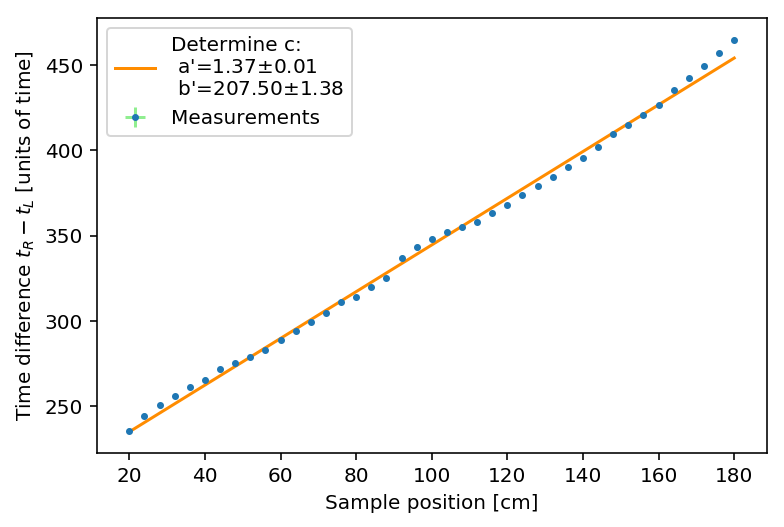

In [9]:
popt,pcov=cf(gerade, pos, muList,sigma=dmuList,p0=[10,300])
perr=np.sqrt(np.diag(pcov))

xrange=np.linspace(pos[0],pos[-1],1000)
fig,ax=plt.subplots(dpi=144)
ax.errorbar(pos,muList,xerr=dpos,yerr=dmuList,fmt=" ",label="Measurements",ecolor="lightgreen",marker=".",markersize=5)
ax.plot(xrange,gerade(xrange,*popt),color="darkorange",
        label="Determine c: \n a'={o[0]:.2f}$\pm${e[0]:.2f} \n b'={o[1]:.2f}$\pm${e[1]:.2f}".format(o=popt,e=perr))
ax.set(xlabel="Sample position [cm]",ylabel="Time difference $t_R - t_L$ [units of time]")
ax.legend()

fig.savefig("Plots/PosTimeUnit.png")

# das selbe noch mal mit yAchse: ns -- Umrechnung durch 100ns=729 \pm 20 Zeiteinheiten
# BEACHTE: FEHLERFORTPFLANZUNG

Geschwindigkeit [c]: 17.9560142983 $\pm$ 0.148559907065 %


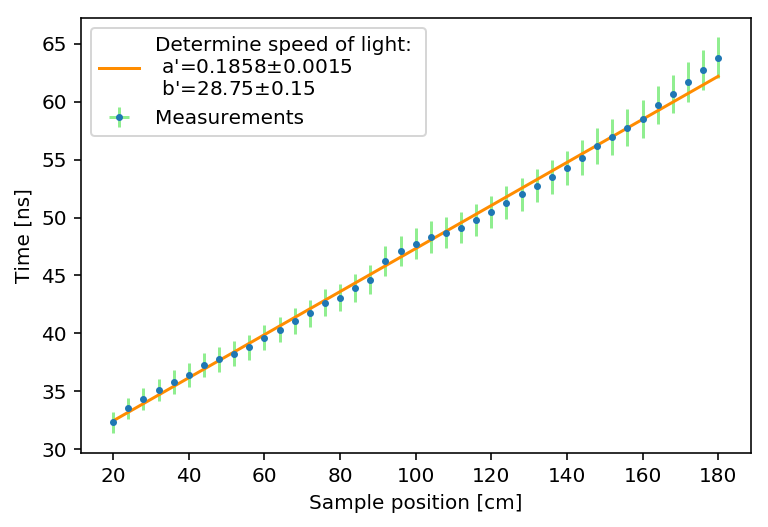

In [5]:
# Umrechnung
a,da=7.29,.2
dtime=np.sqrt( (dmuList/a)**2 + (muList * da / a**2)**2 )
time=muList/ a

popt,pcov=cf(gerade, pos, time,sigma=dtime,p0=[10,300])
perr=np.sqrt(np.diag(pcov))

xrange=np.linspace(pos[0],pos[-1],1000)
fig,ax=plt.subplots(dpi=144)
ax.errorbar(pos,time,xerr=dpos,yerr=dtime,fmt=" ",label="Measurements",ecolor="lightgreen",marker=".",markersize=5)
ax.plot(xrange,gerade(xrange,*popt),color="darkorange",
        label="Determine speed of light: \n a'={o[0]:.4f}$\pm${e[0]:.4f} \n b'={o[1]:.2f}$\pm${e[1]:.2f}".format(o=popt,e=perr))
ax.set(xlabel="Sample position [cm]",ylabel="Time [ns]")
ax.legend()

fig.savefig("Plots/PosTime.png")

print("Geschwindigkeit [c]:", 1/popt[0] *1e9 /c.c, r"$\pm$", perr[0]/popt[0]**2 *1e9 /c.c, "%")